In [59]:
import pandas as pd

# Load the dataset
results_df = pd.read_csv('results.csv')

# Convert date column to datetime
results_df['date'] = pd.to_datetime(results_df['date'])

# Filter matches from the last 20 years
results_df = results_df[results_df['date'] >= '2008-01-01']

In [60]:
# Feature engineering: Calculate goal differential
results_df['goal_differential'] = results_df['home_score'] - results_df['away_score']

# Calculate home team statistics
home_stats = results_df.groupby('home_team').agg(
    home_matches=('home_team', 'count'),
    home_wins=('goal_differential', lambda x: (x > 0).sum()),
    home_goals_scored=('home_score', 'sum'),
    home_goals_conceded=('away_score', 'sum'),
    home_goal_differential=('goal_differential', 'sum')
)

# Calculate away team statistics
away_stats = results_df.groupby('away_team').agg(
    away_matches=('away_team', 'count'),
    away_wins=('goal_differential', lambda x: (x < 0).sum()),  # Negative differential means away win
    away_goals_scored=('away_score', 'sum'),
    away_goals_conceded=('home_score', 'sum'),
    away_goal_differential=('goal_differential', lambda x: -x.sum())  # Reverse sign for away stats
)

# Combine home and away statistics
team_stats = home_stats.join(away_stats, how='outer').fillna(0)

# Aggregate overall team statistics
team_stats['total_matches'] = team_stats['home_matches'] + team_stats['away_matches']
team_stats['total_wins'] = team_stats['home_wins'] + team_stats['away_wins']
team_stats['total_goals_scored'] = team_stats['home_goals_scored'] + team_stats['away_goals_scored']
team_stats['total_goals_conceded'] = team_stats['home_goals_conceded'] + team_stats['away_goals_conceded']
team_stats['total_goal_differential'] = team_stats['home_goal_differential'] + team_stats['away_goal_differential']

# Calculate performance metrics
team_stats['win_rate'] = team_stats['total_wins'] / team_stats['total_matches']
team_stats['average_goals_per_match'] = team_stats['total_goals_scored'] / team_stats['total_matches']

# Fill missing values for safety (e.g., if a team has no matches)
team_stats = team_stats.fillna(0)

# Calculate performance score (weighted by win rate and goals scored)
team_stats['performance_score'] = (
    team_stats['win_rate'] * 0.6 +
    (team_stats['total_goals_scored'] / team_stats['total_goals_scored'].max()) * 0.4
)

# Rank teams by performance score
team_stats['rank'] = team_stats['performance_score'].rank(ascending=False)

# Reset index for easier manipulation
team_stats = team_stats.reset_index()

# Extract the top 10 teams based on performance score
top_10_teams = team_stats.nsmallest(10, 'rank')

# Display the top 10 teams
print("Top 10 Teams Based on Performance Score:")
print(top_10_teams[['index', 'total_matches', 'total_wins', 'win_rate', 'performance_score', 'rank']])

# Get the list of top 10 teams
top_10_team_names = top_10_teams['index'].tolist()


Top 10 Teams Based on Performance Score:
             index  total_matches  total_wins  win_rate  performance_score  \
255          Spain          228.0       163.0  0.714912           0.828947   
37          Brazil          224.0       151.0  0.674107           0.760358   
103        Germany          223.0       134.0  0.600897           0.752173   
136          Japan          247.0       146.0  0.591093           0.747812   
12       Argentina          226.0       141.0  0.623894           0.703614   
185    Netherlands          208.0       125.0  0.600962           0.700501   
174         Mexico          293.0       160.0  0.546075           0.697987   
211       Portugal          215.0       129.0  0.600000           0.694601   
84         England          206.0       126.0  0.611650           0.687903   
288  United States          268.0       143.0  0.533582           0.685929   

     rank  
255   1.0  
37    2.0  
103   3.0  
136   4.0  
12    5.0  
185   6.0  
174   7.0  
211 

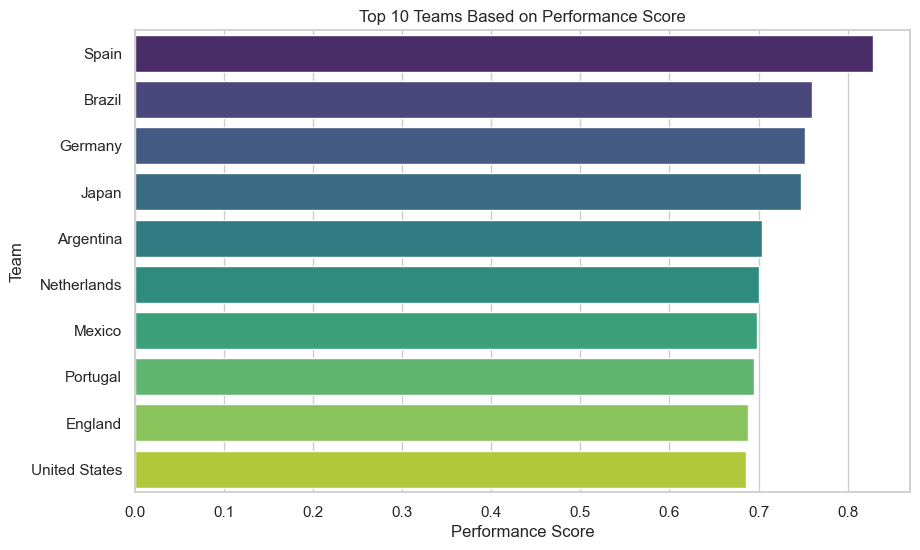

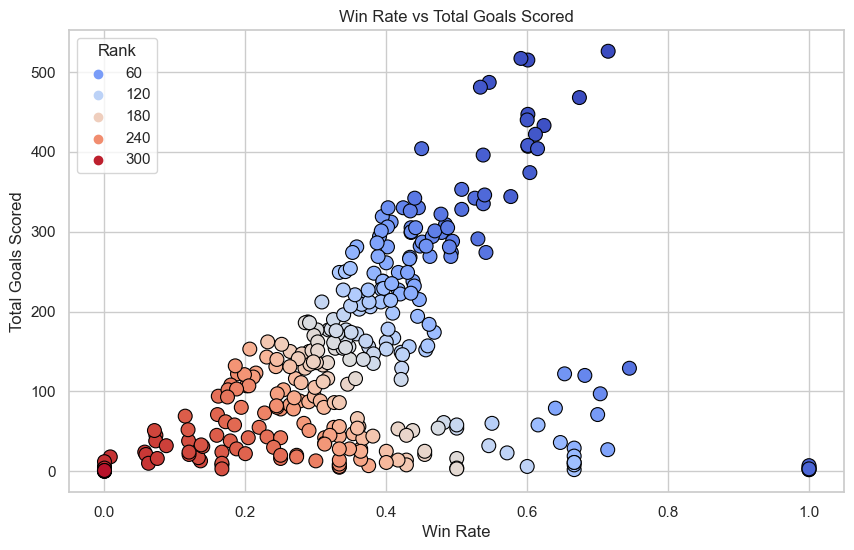

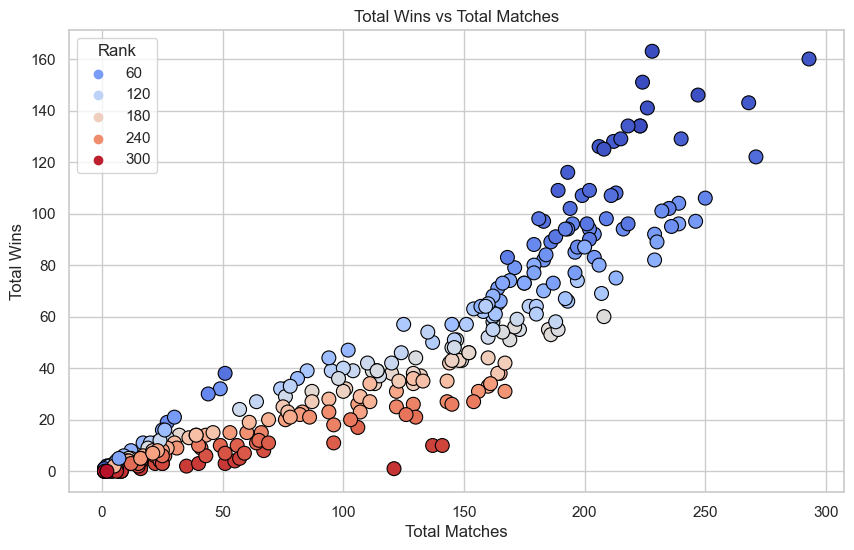

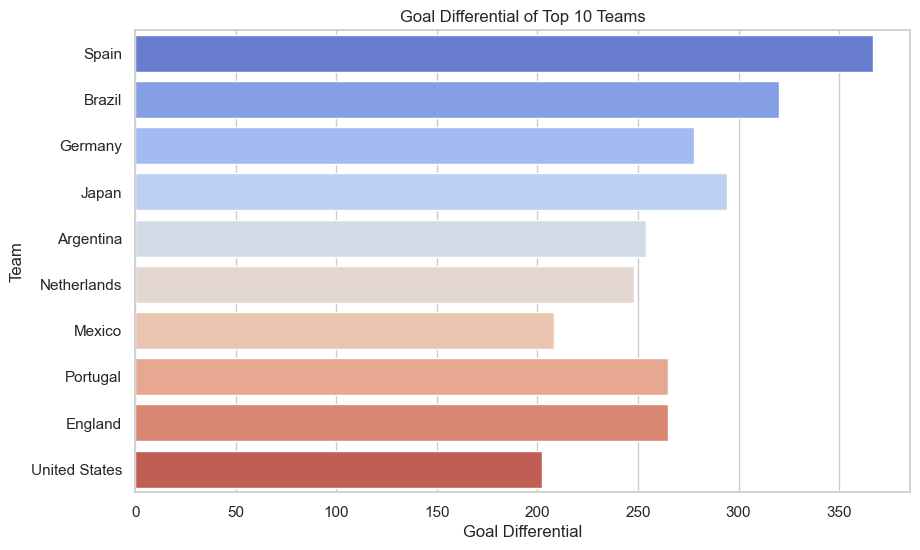

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# 1. Plot the performance score of the top 10 teams
plt.figure(figsize=(10, 6))
sns.barplot(x='performance_score', y='index', data=top_10_teams, palette='viridis')
plt.title('Top 10 Teams Based on Performance Score')
plt.xlabel('Performance Score')
plt.ylabel('Team')
plt.show()

# 2. Scatter plot: Win Rate vs Total Goals Scored
plt.figure(figsize=(10, 6))
sns.scatterplot(x='win_rate', y='total_goals_scored', data=team_stats, hue='rank', palette='coolwarm', s=100, edgecolor='black')
plt.title('Win Rate vs Total Goals Scored')
plt.xlabel('Win Rate')
plt.ylabel('Total Goals Scored')
plt.legend(title='Rank', loc='upper left')
plt.show()

# 3. Scatter plot: Total Wins vs Total Matches
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_matches', y='total_wins', data=team_stats, hue='rank', palette='coolwarm', s=100, edgecolor='black')
plt.title('Total Wins vs Total Matches')
plt.xlabel('Total Matches')
plt.ylabel('Total Wins')
plt.legend(title='Rank', loc='upper left')
plt.show()

# 4. Bar plot: Goal Differential of Top 10 Teams
plt.figure(figsize=(10, 6))
sns.barplot(x='total_goal_differential', y='index', data=top_10_teams, palette='coolwarm')
plt.title('Goal Differential of Top 10 Teams')
plt.xlabel('Goal Differential')
plt.ylabel('Team')
plt.show()


In [62]:
# Filter underdog vs top 10 teams
# Set team names as index for team_stats if not already
team_stats = team_stats.set_index('index')

# Filter matches where one team is from the top 10
underdog_vs_top10 = results_df[results_df['home_team'].isin(top_10_team_names) | results_df['away_team'].isin(top_10_team_names)]

# Create target variable: 1 if underdog wins, 0 otherwise
def create_target(row, top_10_teams):
    if row['home_team'] in top_10_teams:
        return 1 if row['away_score'] > row['home_score'] else 0
    elif row['away_team'] in top_10_teams:
        return 1 if row['home_score'] > row['away_score'] else 0
    return 0

underdog_vs_top10['win'] = underdog_vs_top10.apply(create_target, axis=1, top_10_teams=top_10_team_names)

# Merge home team statistics
underdog_vs_top10 = underdog_vs_top10.merge(
    team_stats[['total_matches', 'total_wins', 'win_rate', 'performance_score']], 
    left_on='home_team', 
    right_index=True, 
    suffixes=('_home', '_away')
)

# Merge away team statistics
underdog_vs_top10 = underdog_vs_top10.merge(
    team_stats[['total_matches', 'total_wins', 'win_rate', 'performance_score']], 
    left_on='away_team', 
    right_index=True, 
    suffixes=('_home', '_away')
)

# Add additional features like home/away, team rank, etc.
underdog_vs_top10['is_home'] = (underdog_vs_top10['home_team'].isin(top_10_team_names)).astype(int)
underdog_vs_top10['home_rank'] = underdog_vs_top10['home_team'].apply(lambda x: 1 if x in top_10_team_names else 0)
underdog_vs_top10['away_rank'] = underdog_vs_top10['away_team'].apply(lambda x: 1 if x in top_10_team_names else 0)

from sklearn.model_selection import train_test_split

# Features and target
X = underdog_vs_top10[['total_matches_home', 'total_wins_home', 'win_rate_home', 'performance_score_home',
                       'total_matches_away', 'total_wins_away', 'win_rate_away', 'performance_score_away', 'is_home']]
y = underdog_vs_top10['win']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_gb = gb_model.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

from sklearn.metrics import roc_auc_score, confusion_matrix

# Evaluate using ROC AUC
roc_auc_lr = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc_gb = roc_auc_score(y_test, gb_model.predict_proba(X_test)[:, 1])

print("Logistic Regression ROC AUC:", roc_auc_lr)
print("Random Forest ROC AUC:", roc_auc_rf)
print("Gradient Boosting ROC AUC:", roc_auc_gb)

from sklearn.model_selection import GridSearchCV

# Example for Random Forest hyperparameter tuning
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)


C:\Users\kyloc\AppData\Local\Temp\ipykernel_71924\1397840115.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  underdog_vs_top10['win'] = underdog_vs_top10.apply(create_target, axis=1, top_10_teams=top_10_team_names)


Logistic Regression Accuracy: 0.8411214953271028
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       359
           1       1.00      0.01      0.03        69

    accuracy                           0.84       428
   macro avg       0.92      0.51      0.47       428
weighted avg       0.87      0.84      0.77       428

Random Forest Accuracy: 0.8317757009345794
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       359
           1       0.45      0.20      0.28        69

    accuracy                           0.83       428
   macro avg       0.66      0.58      0.59       428
weighted avg       0.80      0.83      0.80       428

Gradient Boosting Accuracy: 0.8247663551401869
              precision    recall  f1-score   support

           0       0.85      0.97      0.90       359
           1       0.33      0.09      0.14        69

    accuracy                           0.82

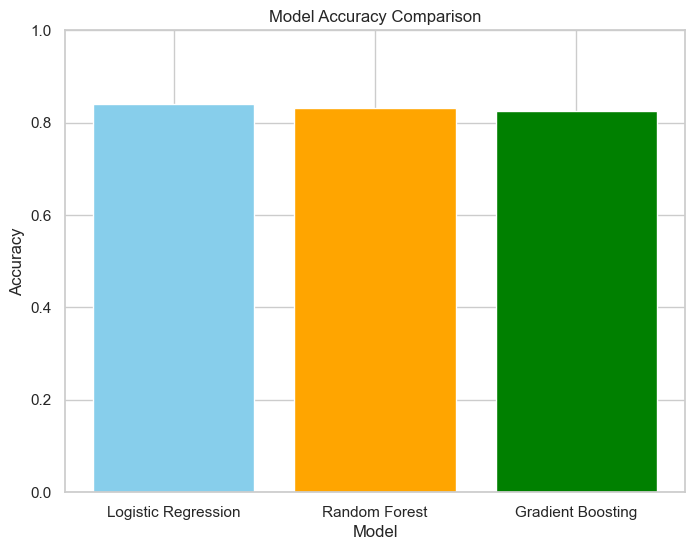

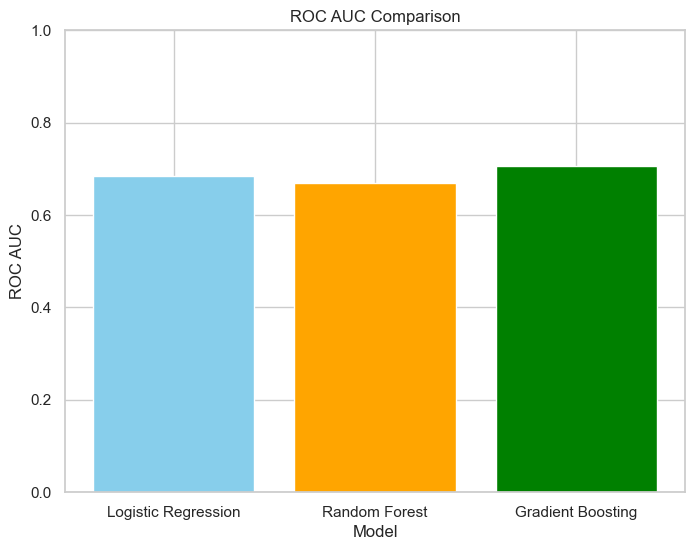

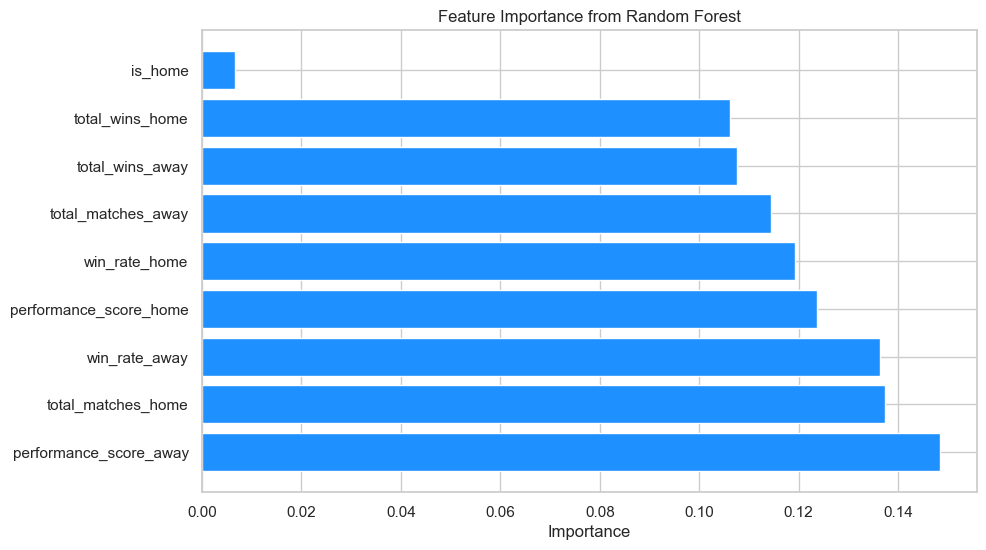

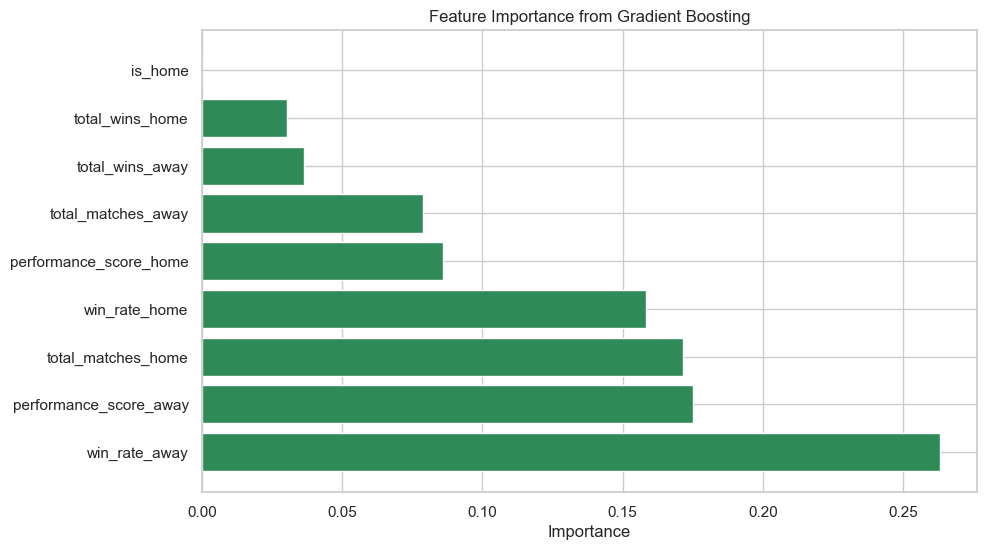

In [63]:
import matplotlib.pyplot as plt

# Define the accuracies for each model
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
accuracies = [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_gb)]

# Plot accuracy comparison
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

# Define the ROC AUC scores for each model
roc_auc_scores = [roc_auc_lr, roc_auc_rf, roc_auc_gb]

# Plot ROC AUC comparison
plt.figure(figsize=(8, 6))
plt.bar(models, roc_auc_scores, color=['skyblue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Comparison')
plt.ylim(0, 1)
plt.show()

import pandas as pd

# Get feature importance from the Random Forest model
importances = rf_model.feature_importances_
features = X.columns

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='dodgerblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.show()

# Get feature importance from Gradient Boosting model
gb_importances = gb_model.feature_importances_

# Create a DataFrame for visualization
gb_feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': gb_importances})
gb_feature_importance_df = gb_feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(gb_feature_importance_df['Feature'], gb_feature_importance_df['Importance'], color='seagreen')
plt.xlabel('Importance')
plt.title('Feature Importance from Gradient Boosting')
plt.show()
